In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys, math
from tqdm.notebook import tqdm
import copy

import csv
import re

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from einops import rearrange, reduce, repeat

In [4]:
import parser
import transformer
import longrange
import dataset
import train
import util

In [5]:
ds_train, ds_test = dataset.load_dataset(tqdm=tqdm)

Found existing dataset at ../data/datasets.pkl


In [6]:
import wandb

In [7]:
wandb

<module 'wandb' from '/afs/csail.mit.edu/u/a/akumar01/miniconda3/lib/python3.9/site-packages/wandb/__init__.py'>

In [8]:
import pandas as pd 
import wandb

api = wandb.Api()
entity, project = "akarshkumar0101", "transformer-memory-skip"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

#     # .config contains the hyperparameters.
#     #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

#     # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

# runs_df.to_csv("project.csv")

In [9]:
df = runs_df
df

,summary,config,name
0,"{'_timestamp': 1663614622.201718, 'loss': 1.35...","{'lr': 0.001, 'seed': 0, 'model': 'longrange2'...",exalted-haze-78
1,"{'_wandb': {'runtime': 250}, '_runtime': 247.2...","{'lr': 0.001, 'seed': 0, 'model': 'longrange1'...",splendid-field-76
2,"{'_timestamp': 1663614130.916306, 'loss': 1.47...","{'lr': 0.001, 'seed': 0, 'model': 'longrange2'...",fast-butterfly-79
3,"{'loss1': 1.5435222387313845, 'loss2': 1.62883...","{'lr': 0.001, 'seed': 0, 'model': 'longrange2'...",swift-violet-76
4,"{'_wandb': {'runtime': 493}, '_runtime': 490.1...","{'lr': 0.001, 'seed': 0, 'model': 'longrange1'...",treasured-moon-75
5,"{'loss': 1.35530424118042, '_step': 1999, 'los...","{'lr': 0.001, 'seed': 0, 'model': 'longrange1'...",feasible-plant-74
6,"{'_step': 1999, '_wandb': {'runtime': 198}, '_...","{'lr': 0.001, 'seed': 0, 'model': 'transformer...",fearless-sun-67
7,"{'_step': 1999, '_wandb': {'runtime': 732}, '_...","{'lr': 0.001, 'seed': 0, 'model': 'transformer...",denim-snow-64
8,"{'loss': 1.5653064250946045, '_step': 1999, '_...","{'lr': 0.001, 'seed': 0, 'model': 'perceiver',...",good-armadillo-62
9,"{'_step': 1999, '_wandb': {'runtime': 196}, '_...","{'lr': 0.001, 'seed': 0, 'model': 'perceiver',...",summer-meadow-66


In [10]:
seq_lens, losses = [], []
for name, config, summary in zip(df.name, df.config, df.summary):
    if config['model']=='perceiver':
        seq_lens.append(config['seq_len'])
        losses.append(summary['loss'])

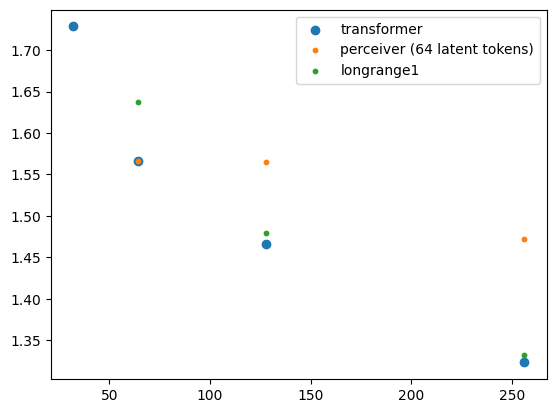

In [11]:
seq_lens, losses = [], []
for name, config, summary in zip(df.name, df.config, df.summary):
    if config['model']=='transformer':
        seq_lens.append(config['seq_len'])
        losses.append(summary['loss'])
plt.scatter(seq_lens, losses, label='transformer')

seq_lens, losses = [], []
for name, config, summary in zip(df.name, df.config, df.summary):
    if config['model']=='perceiver':
        seq_lens.append(config['seq_len'])
        losses.append(summary['loss'])
plt.scatter(seq_lens, losses, label='perceiver (64 latent tokens)', s=10.)
plt.legend()

seq_lens, losses = [], []
for name, config, summary in zip(df.name, df.config, df.summary):
    if config['model']=='longrange1':
        seq_lens.append(config['seq_len'])
        losses.append(summary['loss2'])
plt.scatter(seq_lens, losses, label='longrange1', s=10.)
plt.legend()

In [12]:
for name, config, summary in zip(df.name, df.config, df.summary):
    if config['model']=='transformer' and config['seq_len']==128:
        print(name)
        net_original = torch.load(f'../results/{name}.net').cpu()
        break
for name, config, summary in zip(df.name, df.config, df.summary):
    if config['model']=='longrange1' and config['seq_len']==128:
        print(name)
        net_longrange = torch.load(f'../results/{name}.net').cpu()
        break
        

usual-shape-61
treasured-moon-75


In [19]:
device = 'cuda:0'

In [58]:
def loss_disect(net, ids1, ids2):
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    inputs1, targets1 = ids1[..., :-1], ids1[..., 1:]  # ..., context_length-1
    inputs2, targets2 = ids2[..., :-1], ids2[..., 1:]  # ..., context_length-1
    
    # print(parser.ids2text(inputs1[0].cpu()))
    # print('------------------------------------')
    # print(parser.ids2text(inputs2[0].cpu()))
    # print('------------------------------------\n\n\n')
    
    # print(inputs1.shape, targets1.shape)

    logits1, memory1 = net.forward(inputs1, memory_in=None, calc_memory_out=True)
    # memory1 = torch.randn_like(memory1)
    # memory1 = torch.randn(1, 10, 384).to(memory1)
    # memory1 = None
    logits2, memory2 = net.forward(inputs2, memory_in=memory1, calc_memory_out=False)
    # -1, context_length-1, n_vocab
    loss1 = transformer.fn_cross_entropy(
        logits1.reshape(-1, logits1.size(-1)), targets1.reshape(-1)
    )
    loss2 = transformer.fn_cross_entropy(
        logits2.reshape(-1, logits2.size(-1)), targets2.reshape(-1)
    )
    
    # loss1_ctx = loss_fn(logits1.reshape(-1, logits1.size(-1)), targets1.reshape(-1))
    # loss2_ctx = loss_fn(logits2.reshape(-1, logits2.size(-1)), targets2.reshape(-1))
    # plt.plot(loss1_ctx.detach().cpu().numpy())
    # plt.plot(loss2_ctx.detach().cpu().numpy())
    # plt.xlim(120, 128)
    # plt.show()
    
    out2 = logits2.argmax(dim=-1)
#     print((out2==targets2).sum())
#     print(out2.shape)
#     print(targets2.shape)
    
#     print(logits2.softmax(dim=-1).max(dim=-1).values)
    
    
    loss = (loss1 + loss2) / 2.0
    return loss, loss1, loss2


np.random.seed(1)
torch.manual_seed(1)
net_longrange.train()
net_longrange.to(device)
loss1s, loss2s = [], []
n_batches = 1000
for batch1, batch2 in tqdm(dataset.get_random_skip_batches(ds_train, n_batches, 32, 128, 4*128, 10*128), total=n_batches):
    batch1, batch2 = batch1.to(device).long(), batch2.to(device).long()
    loss, loss1, loss2 = loss_disect(net_longrange, batch1, batch2)
    loss1s.append(loss1.detach().cpu())
    loss2s.append(loss2.detach().cpu())
loss1s = torch.stack(loss1s)
loss2s = torch.stack(loss2s)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [59]:
torch.mean(loss1s), torch.mean(loss2s)

(tensor(1.4442), tensor(1.4415))

In [47]:
torch.mean(loss1s), torch.mean(loss2s)

(tensor(1.4452), tensor(1.4409))

In [192]:
def test_model(net, n_seqs=4, device='cpu'):
    np.random.seed(1)
    torch.manual_seed(1)
    
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    
    net_longrange.eval()
    net_longrange.to(device)
    
    losses = [[] for _ in range(n_seqs)]
    
    ds = ds_train
    n_batches, batch_size = 1000, 32
    seq_len = 128
    pbar = dataset.get_random_batches_new(ds, n_batches, batch_size, n_seqs, seq_len, min_dist=0, max_dist=1, unbind=True)
    for batch_ids, batch_freqs in tqdm(pbar, total=n_batches):
        memory = None
        for idx_seq, (seq_ids, seq_freqs) in enumerate(zip(batch_ids, batch_freqs)):
            seq_ids, seq_freqs = seq_ids.to(device).long(), seq_freqs.to(device).long()
            logits_i, memory_i = net.forward(seq_ids, memory_in=memory, calc_memory_out=True)
            # print(seq_ids.shape, seq_freqs.shape)
            memory = memory_i if memory is None else torch.cat([memory, memory_i], dim=-2)
            # print(memory.shape)
            
            a = logits_i[..., :-1, :].reshape(-1, logits_i.shape[-1])
            b = seq_ids[..., 1:].reshape(-1)
            loss = loss_fn(a, b).reshape(batch_size, -1).mean(dim=0).detach().cpu()
            # print(loss.shape)
            losses[idx_seq].append(loss)
    return losses
            
losses = test_model(net_longrange, device='cuda:4')



  0%|          | 0/1000 [00:00<?, ?it/s]

In [195]:
a = [torch.stack(a).mean(dim=0).mean() for a in losses]
print(a)
a = torch.cat([torch.stack(a).mean(dim=0) for a in losses], dim=0)

[tensor(1.4096), tensor(1.4066), tensor(1.4050), tensor(1.4055)]


(1.3, 1.5)

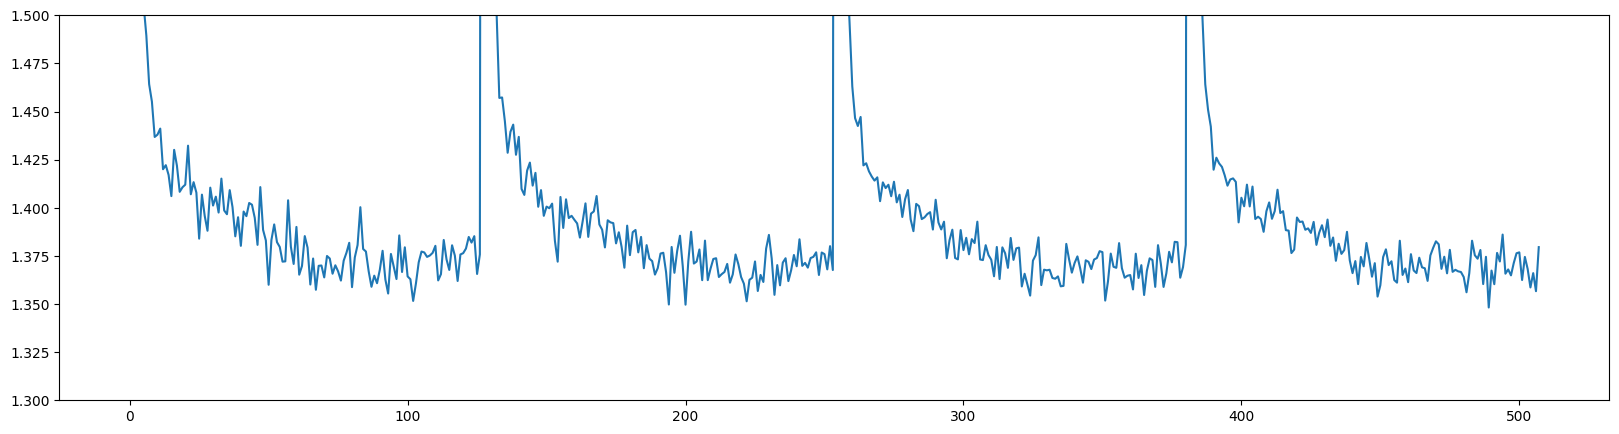

In [194]:
plt.figure(figsize=(20, 5))
plt.plot(a)
plt.ylim(1.3, 1.5)

In [216]:
def test_model(net, n_seqs=4, device='cpu'):
    np.random.seed(1)
    torch.manual_seed(1)
    
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    
    net_longrange.eval()
    net_longrange.to(device)
    
    # losses = [[] for _ in range(n_seqs)]
    
    ds = ds_train
    n_batches, batch_size = 500, 32
    seq_len = 128
    losses = torch.zeros(n_batches, n_seqs, 11)
    pbar = dataset.get_random_batches_new(ds, n_batches, batch_size, n_seqs, seq_len, min_dist=0, max_dist=1, unbind=True)
    for idx_batch, (batch_ids, batch_freqs) in enumerate(tqdm(pbar, total=n_batches)):
        memory = None
        for idx_seq, (seq_ids, seq_freqs) in enumerate(zip(batch_ids, batch_freqs)):
            seq_ids, seq_freqs = seq_ids.to(device).long(), seq_freqs.to(device).long()
            logits_i, memory_i = net.forward(seq_ids, memory_in=memory, calc_memory_out=True)
            # print(seq_ids.shape, seq_freqs.shape)
            memory = memory_i if memory is None else torch.cat([memory, memory_i], dim=-2)
            # print(memory.shape)
            
            a = logits_i[..., :-1, :].reshape(-1, logits_i.shape[-1])
            b = seq_ids[..., 1:].reshape(-1)
            loss = loss_fn(a, b).reshape(batch_size, -1).detach().cpu()
            seq_freqs = seq_freqs[..., 1:]
            
            for idx_fbin, fbin in enumerate(range(-2, 9)):
                li = loss.flatten()[seq_freqs.flatten()==fbin].mean().item()
                losses[idx_batch, idx_seq, idx_fbin] = li
    return losses
            
losses = test_model(net_longrange, device='cuda:5')


  0%|          | 0/500 [00:00<?, ?it/s]

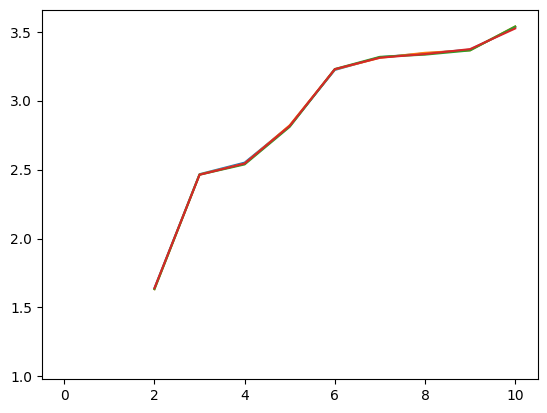

In [217]:
for li in losses.mean(dim=0):
    plt.plot(li)

In [ ]:
# next steps:
# replicate these results
# document it

# track long-range gradient over tracking
# track long range attn matrix
# graph gradient magnitude vs T
# graph loss vs word frequency bin for transformer, perceiver, longrange1 (first, second, third seq)

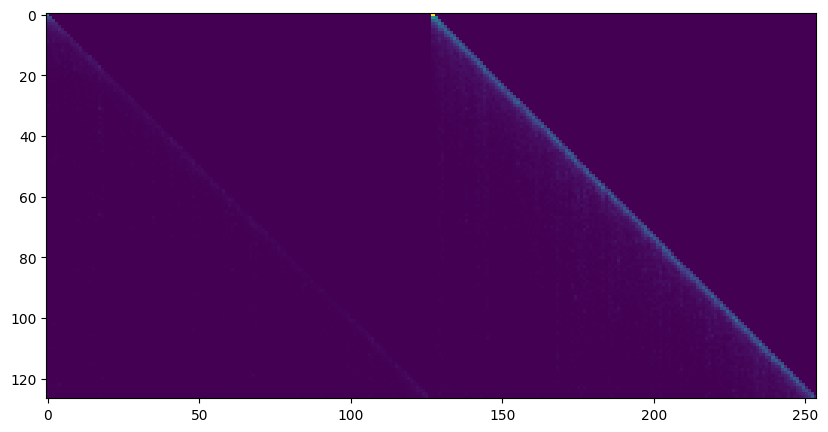

In [38]:
plt.figure(figsize=(20, 5))
plt.imshow(net_longrange.blocks_main[4].attn_weights.mean(dim=0).detach().cpu().numpy())

In [154]:

ds = {'book': dict(ids=parser.text2ids('abcdefghijklmnopqrstuvwxyz'), fbin_fchars=parser.text2ids('abcdefghijklmnopqrstuvwxyz'))}
for (a,b), (c, d) in get_random_batches_new(ds, 1, 3, 2, 5, 8, 9):
    print(a.shape, b.shape)
    print(c.shape, d.shape)
    print()

torch.Size([3, 5]) torch.Size([3, 5])
torch.Size([3, 5]) torch.Size([3, 5])

